In [ ]:
import torch
class a_opt(torch.optim.lr_scheduler.LRScheduler):
    def __init__(self, x):
        pass
        
model = torch.nn.LSTM(100, 100)
c = a_opt(torch.optim.AdamW(model.parameters(), lr=0.1))
isinstance(c, torch.optim.lr_scheduler.LRScheduler)

In [ ]:
import torch
class outProd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, branch, trunk):
        b, p = branch.shape[0], trunk.shape[0]
        branch = branch.expand(b, p)
        trunk = trunk.expand(b, p)
        ctx.save_for_backward(branch, trunk)
        return branch * trunk
    @staticmethod
    def backward(ctx, grad_output):
        branch, trunk = ctx.saved_tensors
        grad_input = grad_output.clone()
        print(grad_input.shape, branch.shape, trunk.shape)
        branch_grad = grad_input * trunk
        trunk_grad = grad_input * branch
        print(branch_grad.shape, trunk_grad.shape)
        return branch_grad, trunk_grad


x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[...,None].requires_grad_()
a = outProd.apply(x,y)
print(a)
torch.autograd.grad(a, y, grad_outputs= torch.ones_like(a),retain_graph=True)

In [ ]:
x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[None,...].requires_grad_()
a = torch.outer(x, y)

In [ ]:
a = torch.ones(10, 10)
b = torch.linspace(0, 1, 10)[None,...]
print(a * b)

In [ ]:
import torch.nn as nn
class originDeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        out = torch.einsum("b i, p i -> b p", branch, trunk)
        return out
    
class DeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        p, b = x[1].shape[0], x[0].shape[0]
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        branch = branch.unsqueeze(1).expand(b, p, 10)
        trunk = trunk.unsqueeze(0).expand(b, p, 10)
        return (branch * trunk).sum(-1)
    
netA = originDeepONetCard()
netB = DeepONetCard()
a = torch.ones(10, 1)
b = torch.linspace(0, 1, 10)[..., None].requires_grad_()
x = (a, b)
A = netA(x)
B = netB(x)
print(torch.autograd.grad(A, b, grad_outputs= torch.ones_like(A),retain_graph=True)[0])
print(torch.autograd.grad(B, b, grad_outputs= torch.ones_like(B),retain_graph=True)[0])

In [1]:
import torch
from torch import nn
import time
class net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        return self.a(x)

y = net()
a = torch.randn(1, 10, requires_grad=True)
a = a.expand(1000, 10)
b = a.mean(0, keepdim=True)
out = y(a)
print(out.shape)
grad_batched = torch.eye(1000)[...,None]
grad = torch.autograd.grad(out, a, grad_outputs= grad_batched,retain_graph=True, is_grads_batched=True)[0]
print(grad)
for i in y.parameters():
    print(i)

torch.Size([1000, 1])
tensor([[[ 0.0016, -0.0471, -0.2148,  ..., -0.0615,  0.2788,  0.0963],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0016, -0.0471, -0.2148,  ..., -0.0615,  0.2788,  0.0963],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0

In [1]:
import torch
from torch import nn
import time
class DeepOnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(10, 10)
        self.trunk = nn.Linear(1, 10)
    
    def forward(self, b, t, mode = "a"):
        if mode == "a":
            branch = self.branch(b)
            trunk = self.trunk(t)
            return torch.einsum("b i, p i -> b p", branch, trunk)
        else:
            t = t.mean(0) # p, 1
            branch = self.branch(b) # b, 10
            trunk = self.trunk(t) # p, 10
            return torch.einsum("b i, p i -> b p", branch, trunk)

batch = 600
y = DeepOnet().cuda()
trunk_inp = torch.randn(1000, 1, requires_grad=True, device="cuda")
branch_inp = torch.randn(batch, 10, requires_grad=True, device="cuda")
out = y(branch_inp, trunk_inp, mode="a")

# 1000 x 1000 x 1; b, p, 1

In [2]:
torch.cuda.empty_cache()
t = time.time()
grad2 = []
for i in out:
    grad2.append(torch.autograd.grad(i, trunk_inp, grad_outputs= torch.ones_like(i),retain_graph=True, create_graph=True)[0])
grad2 = torch.stack(grad2)
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad2.shape)
#print(grad2)
print(time.time() - t)

1487258112 1489715712
torch.Size([600, 1000, 1])
12.440793752670288


In [2]:
torch.cuda.empty_cache()
t = time.time()
for i in range(1):
    out = y(branch_inp, trunk_inp, mode="a")

grad_batched = torch.eye(batch, device = "cuda")[...,None].expand(batch, batch, 1000)
print(grad_batched.shape, out.shape)
grad3 = torch.autograd.grad(out, trunk_inp, grad_outputs= grad_batched,retain_graph=True, is_grads_batched= True, create_graph=True)[0]
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad3.shape)

print(time.time() - t)

torch.Size([600, 600, 1000]) torch.Size([600, 1000])
48334848 1486678016
torch.Size([600, 1000, 1])
0.022984743118286133


In [6]:
print((grad2 - grad3 > 1e-6).sum())

tensor(0, device='cuda:0')


(505,) (1, 101)


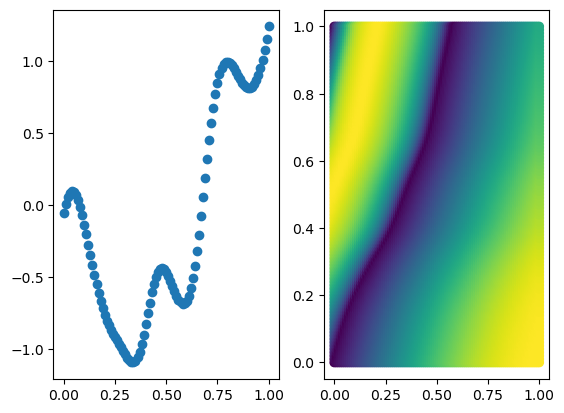

In [11]:
import deepxde.deepxde as dde
import numpy as np
f = dde.data.GRF(length_scale=0.1)
fea = f.random(1)
func = f.eval_batch(fea, np.linspace(0, 1, 101)[:, None])
from datasets.solver import advection_solver
xt, u = advection_solver(func)

import matplotlib.pyplot as plt
fig , (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(np.linspace(0, 1, 101), func[0])
xt = xt.reshape(-1, 2)
u = u.reshape(-1, 1)
ax2.scatter(xt[:, 0], xt[:, 1], c = u)

In [7]:
xt.shape

(101, 101, 2)